In [1]:
!pip install --upgrade libpysal esda

import pandas as pd
import numpy as np 
import re
from datetime import datetime 
import ast
from collections import Counter
from collections import OrderedDict
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# Install external packages separately through the command line or using !pip in Jupyter
# Example:
!pip install urbanaccess
!pip install pandana

#insert file_path for the data
file_path = 'C:/Users/anton/Documents/2de_master/Thesis/Code/analysis/Code/Airbnb_Spatiotemporal_Analysis/Paris Airbnb_Spatiotemporal_Analysis/Baseline models/Combined_data_paris.csv'
#read data, and quickly check if it is correctly read in
dataframe1= pd.read_csv(file_path)

In [ ]:
dataframe1['date'] = pd.to_datetime(dataframe1['date'])

In [ ]:
dataframe1.info()

In [ ]:
# Checking the distributions of the review ratings columns
variables_to_plot = list(dataframe1.columns[dataframe1.columns.str.startswith("review_scores") == True])
fig = plt.figure(figsize=(12,8))
for i, var_name in enumerate(variables_to_plot):
    ax = fig.add_subplot(3,3,i+1)
    dataframe1[var_name].hist(bins=10,ax=ax)
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

#out of these we see that most of them are rated quite positive, with the biggest amount around 4-5/5 stars

In [ ]:
import geopandas as gpd
# Importing the Paris neighbourhood  GeoJSON file as a dataframe in geopandas
map_dataframe1 = gpd.read_file('C:/Users/anton/Documents/2de_master/Thesis/Data/2. airbnb_data/Paris/Q1 airbnb_data Paris/neighbourhoods.geojson')
map_dataframe1.drop('neighbourhood_group', axis = 1, inplace = True)
map_dataframe1.head(20)

In [ ]:
# List of all neighbourhood columns
neighbourhood_cols = [
    'neighbourhood_Batignolles-Monceau', 'neighbourhood_Bourse', 'neighbourhood_Buttes-Chaumont',
    'neighbourhood_Buttes-Montmartre', 'neighbourhood_Entrepôt', 'neighbourhood_Gobelins',
    'neighbourhood_Hôtel-de-Ville', 'neighbourhood_Louvre', 'neighbourhood_Luxembourg',
    'neighbourhood_Ménilmontant', 'neighbourhood_Observatoire', 'neighbourhood_Opéra',
    'neighbourhood_Palais-Bourbon', 'neighbourhood_Panthéon', 'neighbourhood_Passy',
    'neighbourhood_Popincourt', 'neighbourhood_Reuilly', 'neighbourhood_Temple',
    'neighbourhood_Vaugirard', 'neighbourhood_Élysée'
]

def get_neighbourhood(row):
    for col in neighbourhood_cols:
        if row[col]:
            return col.split('_')[1]  # Assuming the format 'neighbourhood_NAME'
    return None  # In case no neighbourhood column is True

# Apply this function to create the new 'neighbourhood' column
dataframe1['neighbourhood'] = dataframe1.apply(get_neighbourhood, axis=1)

In [ ]:
#setting the characteristics for the following plot
plt.rcParams.update({'font.size': 30})
plt.rcParams['figure.figsize'] = 280, 280


# Creating a dataframe of listing counts and median price by neighbourhood
neighbourhood_dataframe1 = pd.DataFrame(dataframe1.groupby('neighbourhood').size())
neighbourhood_dataframe1.rename(columns={0: 'number_of_listings'}, inplace=True)
neighbourhood_dataframe1['median_price'] = dataframe1.groupby('neighbourhood').price.median().values
neighbourhood_dataframe1['mean_price'] = dataframe1.groupby('neighbourhood').price.mean().values

# Putting the dataframes together
neighbourhood_map_dataframe1 = map_dataframe1.set_index('neighbourhood').join(neighbourhood_dataframe1)
                  
# Plotting the number of listings in each neighbourhood
fig1, ax1 = plt.subplots(1, figsize=(15, 6)) #deciding on plot size
neighbourhood_map_dataframe1.plot(column='number_of_listings', cmap='Reds', ax=ax1, rasterized=True) 
#rasterized to makes it easier for big data sets + ax1 earlier defined

ax1.axis('off') #disabling the axis components, including axis labels, ticks, and the frame surrounding the plot
cax1 = fig1.add_axes([0.9, 0.1, 0.03, 0.8]) # Adjusted the position and size as needed for the side axis [left, bottom, width, height]
#ScalarMappable to make a color map + norm, to normalize the coloring within the graph 
sm1 = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=0, vmax=100000))
sm1._A = [] # The primary reason for doing this is to provide an empty array that will later be populated with the data range when the plot is created. The colorbar uses this array to decide the color scaling for the colormap.
cbar1 = fig1.colorbar(sm1, cax=cax1) 
plt.show()

# Plotting the median price of listings in each neighbourhood
fig2, ax2 = plt.subplots(1, figsize=(15, 6))
neighbourhood_map_dataframe1.plot(column='median_price', cmap='Reds', ax=ax2)
ax2.axis('off')
cax2 = fig2.add_axes([0.9, 0.1, 0.03, 0.8])  # Adjusted the position and size as needed for the side axis [left, bottom, width, height]
#ScalarMappable to make a color map + norm, to normalize the coloring within the graph 
sm2 = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=min(neighbourhood_map_dataframe1.median_price), vmax=max(neighbourhood_map_dataframe1.median_price))) 
sm2._A = [] # The primary reason for doing this is to provide an empty array that will later be populated with the data range when the plot is created. The colorbar uses this array to decide the color scaling for the colormap.
cbar2 = fig2.colorbar(sm2, cax=cax2)
plt.show()

# Plotting the mean price of listings in each neighbourhood
fig3, ax3 = plt.subplots(1, figsize=(15, 6))
neighbourhood_map_dataframe1.plot(column='mean_price', cmap='Reds', ax=ax3)
ax3.axis('off')
cax3 = fig3.add_axes([0.9, 0.1, 0.03, 0.8])  # Adjusted the position and size as needed for the side axis [left, bottom, width, height]
#ScalarMappable to make a color map + norm, to normalize the coloring within the graph 
sm3 = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=min(neighbourhood_map_dataframe1.mean_price), vmax=max(neighbourhood_map_dataframe1.mean_price))) 
sm3._A = [] # The primary reason for doing this is to provide an empty array that will later be populated with the data range when the plot is created. The colorbar uses this array to decide the color scaling for the colormap.
cbar3 = fig3.colorbar(sm3, cax=cax3)
plt.show()

print(neighbourhood_dataframe1)

In [ ]:
# Plot number of listings and median price in one bar plot
plt.rcParams['font.size'] = 15
plt.rcParams['figure.figsize'] = 25, 5
selected_columns = ['number_of_listings', 'median_price']
neighbourhood_dataframe1_selected = neighbourhood_dataframe1[selected_columns]
neighbourhood_dataframe1_sorted = neighbourhood_dataframe1_selected.sort_values('median_price', ascending=False)
neighbourhood_dataframe1_sorted.plot( kind= 'bar' , secondary_y= 'median_price' , rot= 90 )
plt.xticks(rotation='vertical')
plt.show()

# Plot number of listings and mean price in one bar plot
plt.rcParams['font.size'] = 15
plt.rcParams['figure.figsize'] = 25, 5
selected_columns = ['number_of_listings', 'mean_price']
neighbourhood_dataframe1_selected = neighbourhood_dataframe1[selected_columns]
neighbourhood_dataframe1_sorted = neighbourhood_dataframe1_selected.sort_values('mean_price', ascending=False)
neighbourhood_dataframe1_sorted.plot( kind= 'bar' , secondary_y= 'mean_price' , rot= 90 )
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

def binary_count_and_price_plot(column_name, alpha=0.05):
    # Assuming dataframe1 is your DataFrame
    
    # Define colors for True and False values
    colors = {True: 'green', False: 'red'}

    # Plot count distribution
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.countplot(x=column_name, data=dataframe1, palette=colors)
    plt.title(f'Count distribution of {column_name}')

    # Plot median price distribution
    plt.subplot(1, 2, 2)
    mean_prices = dataframe1.groupby(column_name)['price'].mean()
    sns.barplot(x=mean_prices.index, y=mean_prices.values, palette=colors)
    plt.title(f'Mean price distribution by {column_name}')
    plt.tight_layout()
    plt.show()

    # Calculate t-test for median prices
    true_prices = dataframe1[dataframe1[column_name] == True]['price']
    false_prices = dataframe1[dataframe1[column_name] == False]['price']
    t_stat, p_value = ttest_ind(true_prices, false_prices)
   
    # Display additional information
    percent_split = dataframe1[column_name].value_counts(normalize=True) * 100
    print(f'% Wise Split of {column_name}:\n{percent_split}')
    
    t_statistic, p_value = ttest_ind(true_prices, false_prices, equal_var=False)  # assuming unequal variances
    print(f'\nP-value for {column_name}: {p_value}')
    
    # Check if p-value is greater than or equal to alpha
    if p_value >= alpha:
        print(f"{column_name} is not statistically significant (p-value >= {alpha})")
        return column_name
    else:
        print(f"{column_name} is statistically significant (p-value < {alpha})")
        return None  # or any other value if needed

superhost = binary_count_and_price_plot('host_is_superhost')
print(dataframe1.host_is_superhost.value_counts(normalize=True))

test2 = binary_count_and_price_plot('host_identity_verified')
print(dataframe1.host_identity_verified.value_counts(normalize=True))

test3 = binary_count_and_price_plot('instant_bookable')
print(dataframe1.instant_bookable.value_counts(normalize=True))

In [ ]:
# Get column names and their indices
column_info = list(enumerate(dataframe1.columns))
# Print column names and their indices
for index, column_name in column_info:
    print(f"Column {index}: {column_name}")
    
#now we know that the amenity columns start from index 51

In [ ]:
dataframe1.columns[36]

In [ ]:
#doing the analysis for all the different amenities
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = 20, 20
column_indices = list(range(36, 100))
result = [binary_count_and_price_plot(col) for col in dataframe1.iloc[:,column_indices].columns]

In [ ]:
#now we are making a comparison against the rating and seeing if having the amenity might impact the rating

def binary_count_and_rating_plot(column_name,alpha=0.05):
    # Only taking the ones with reviews into consideration
    data = dataframe1[[column_name, 'review_scores_rating']].dropna()

    # Plot count distribution
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.countplot(x=column_name, data=data)
    plt.title(f'Count distribution of {column_name}')

    # Plot median price distribution
    plt.subplot(1, 2, 2)
    rating_mean = data.groupby(column_name)['review_scores_rating'].mean()
    rating_mean.plot(kind='bar', color=['blue', 'orange'])
    plt.title(f'Average rating distribution by {column_name}')
    plt.tight_layout()
    plt.show()

    # Calculate t-test for median prices
    true_ratings = data[data[column_name] == True]['review_scores_rating']
    false_ratings = data[data[column_name] == False]['review_scores_rating']
    t_stat, p_value = ttest_ind(true_ratings, false_ratings)
   
    # Display additional information
    percent_split = data[column_name].value_counts(normalize=True) * 100
    print(f'% Wise Split of {column_name}:\n{percent_split}')
    t_statistic, p_value = ttest_ind(true_ratings, false_ratings, equal_var=False)  # assuming unequal variances
    print(f'\nP-value for {column_name}: {p_value}')
    
    # Check if p-value is greater than or equal to alpha
    if p_value >= alpha:
        print(f"{column_name} is not statistically significant (p-value >= {alpha})")
        return column_name
    else:
        print(f"{column_name} is statistically significant (p-value < {alpha})")
        return None  # or any other value if needed
    
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = 20, 20
column_indices = list(range(36, 100))
result = [binary_count_and_rating_plot(dataframe1.columns[col]) for col in column_indices]

In [ ]:
from collections import OrderedDict

def collect_pvalues(columns_of_interest):
    all_pvalues = {}

    for column_name in columns_of_interest:
        # Drop rows with missing values in the specified columns
        data = dataframe1[[column_name, 'price']].dropna()

        # Calculate t-test for median prices
        true_prices = data[data[column_name] == True]['price']
        false_prices = data[data[column_name] == False]['price']
        t_statistic, p_value = ttest_ind(true_prices, false_prices, equal_var=False)  # assuming unequal variances
        all_pvalues[column_name] = {'p_value': p_value, 't_statistic': t_statistic}

    return all_pvalues

columns_of_interest = dataframe1.iloc[:, 51:-2].columns.values
result = collect_pvalues(columns_of_interest)
# Extract p-values and create a dictionary

all_pvalues = {}
for column in result:
    p_value = result[column]['p_value']
    if isinstance(p_value, np.float64):
        all_pvalues[column] = p_value
    else:
        all_pvalues[column] = [float(val) for val in p_value]

import math
#P-values of effects of each amanity on price can be visualized using the 'Manhattan-plot' approach: taking the minus log of the P-value:
# -log Pvalues and order
all_pvalues.update({k: -1*np.log(v) for k, v in all_pvalues.items()})
ordereddict = OrderedDict(sorted(all_pvalues.items(), key=lambda t: t[1]))
plt.rcParams['font.size'] = 10
plt.rcParams['figure.figsize'] = 12, 30
plt.barh(list(ordereddict.keys()), list(ordereddict.values()),color='g', height=0.6)
plt.show()

In [ ]:
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = 16, 8

print(f"Of the Airbnb hosts that are still listing on the site, the first joined on {min(dataframe1.host_since).strftime('%d %B %Y')}, and the most recent joined on {max(dataframe1.host_since).strftime('%d %B %Y')}.")


dataframe1.set_index('host_since').resample('MS').size().plot(label='Hosts joining Airbnb', color='orange')
dataframe1.set_index('first_review').resample('MS').size().plot(label='Listings getting their first review', color='green')
plt.title('Paris hosts registration on Airbnb, numbers of first reviews per accommodation per month')
plt.legend()
plt.xlim('2008-01-01', '2019-11-30') # Limiting to whole months
plt.xlabel('')
plt.ylabel('')
plt.show()

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose


def decompose_time_series(ts, title=''):
    decomposition = seasonal_decompose(ts)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.figure(figsize=(12, 8))

    plt.subplot(411)
    plt.plot(ts, label='Original')
    plt.legend(loc='upper left')
    plt.title(f'{title} - Original')

    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='upper left')
    plt.title(f'{title} - Trend')

    plt.subplot(413)
    plt.plot(seasonal, label='Seasonal')
    plt.legend(loc='upper left')
    plt.title(f'{title} - Seasonal')

    plt.subplot(414)
    plt.plot(residual, label='Residual')
    plt.legend(loc='upper left')
    plt.title(f'{title} - Residual')

    plt.tight_layout()
    plt.show()
    
# Creating dataframes for time series analysis
ts_host_since = pd.DataFrame(dataframe1.set_index('host_since').resample('MS').size())
ts_first_review = pd.DataFrame(dataframe1.set_index('first_review').resample('MS').size())

# Renaming columns
ts_host_since = ts_host_since.rename(columns={0: 'hosts'})
ts_host_since.index.rename('month', inplace=True)
ts_first_review = ts_first_review.rename(columns={0: 'reviews'})
ts_first_review.index.rename('month', inplace=True)

plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = 50, 70
decompose_time_series(ts_host_since, title='Number of registrations on Airbnb by month')

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(dataframe1['reviews_per_month'].dropna(), bins=50, kde=True)
plt.xlabel('Reviews Per Month')
plt.ylabel('Frequency')
plt.title('Reviews Per Month Distribution')
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cut the 'review_scores_value' into categories
categories = pd.cut(dataframe1['review_scores_rating'].dropna(), 4, labels=['Poor', 'Average', 'Good', 'Excellent'])
dataframe1['Lodging Quality'] = categories

# Filter out residences with no customer evaluation
no_nan = dataframe1[~dataframe1['review_scores_rating'].isnull()]

# Set seaborn style
sns.set(style='whitegrid')

# Group by 'Lodging Quality' and calculate the average price for each category
groups = no_nan.groupby('Lodging Quality')['price'].mean()

# Set the figure size
plt.figure(figsize=(8, 6))

# Plot the bar chart with adjusted ylim
chart = groups.plot(kind='bar', ylim=(0, 300), xlabel='', yticks=[], fontsize=12, color=['grey', 'grey', 'darkred', 'grey'])

# Display average prices on top of the bars
for i, price in enumerate(groups):
    plt.text(i, price + 10, f'${price:.2f}', ha='center', va='bottom', fontdict={'size': 12})

# Set the graph title
plt.title('Average Price per Dwelling Quality', fontdict={'size': 15})

# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Showing the distribution between price and the number of bedrooms
figsize = (10, 5)
x = 'bedrooms'

# Create a grid with 1 row and 1 column
fig = plt.figure(figsize=figsize)
gs = GridSpec(1, 1)

# Bar plot for price distribution
ax1 = plt.subplot(gs[0])
sns.barplot(data=dataframe1, x=x, y='price', ax=ax1)
ax1.set_title(f'Distribution of Price based on {x}')

# Calculate the percentage of each bedroom count relative to all listings
bedroom_percentage = dataframe1[x].value_counts(normalize=True) * 100

# Display the percentage of each bedroom count
for bedrooms, percentage in bedroom_percentage.items():
    print(f'The percentage of listings with {bedrooms} bedroom(s) is: {percentage:.2f}%')

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Showing the distribution between price and the number of bedrooms
figsize = (10, 5)
x = 'beds'

# Create a grid with 1 row and 1 column
fig = plt.figure(figsize=figsize)
gs = GridSpec(1, 1)

# Bar plot for price distribution
ax1 = plt.subplot(gs[0])
sns.barplot(data=dataframe1, x=x, y='price', ax=ax1)
ax1.set_title(f'Distribution of Price based on {x}')

# Calculate the percentage of each bedroom count relative to all listings
bedroom_percentage = dataframe1[x].value_counts(normalize=True) * 100

# Display the percentage of each bedroom count
for bedrooms, percentage in bedroom_percentage.items():
    print(f'The percentage of listings with {bedrooms} bedroom(s) is: {percentage:.2f}%')

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Showing the distribution between price and the number of bedrooms
figsize = (10, 5)
x = 'bathrooms'

# Create a grid with 1 row and 1 column
fig = plt.figure(figsize=figsize)
gs = GridSpec(1, 1)

# Bar plot for price distribution
ax1 = plt.subplot(gs[0])
sns.barplot(data=dataframe1, x=x, y='price', ax=ax1)
ax1.set_title(f'Distribution of Price based on {x}')

# Calculate the percentage of each bedroom count relative to all listings
bedroom_percentage = dataframe1[x].value_counts(normalize=True) * 100

# Display the percentage of each bedroom count
for bedrooms, percentage in bedroom_percentage.items():
    print(f'The percentage of listings with {bedrooms} bedroom(s) is: {percentage:.2f}%')

plt.tight_layout()
plt.show()

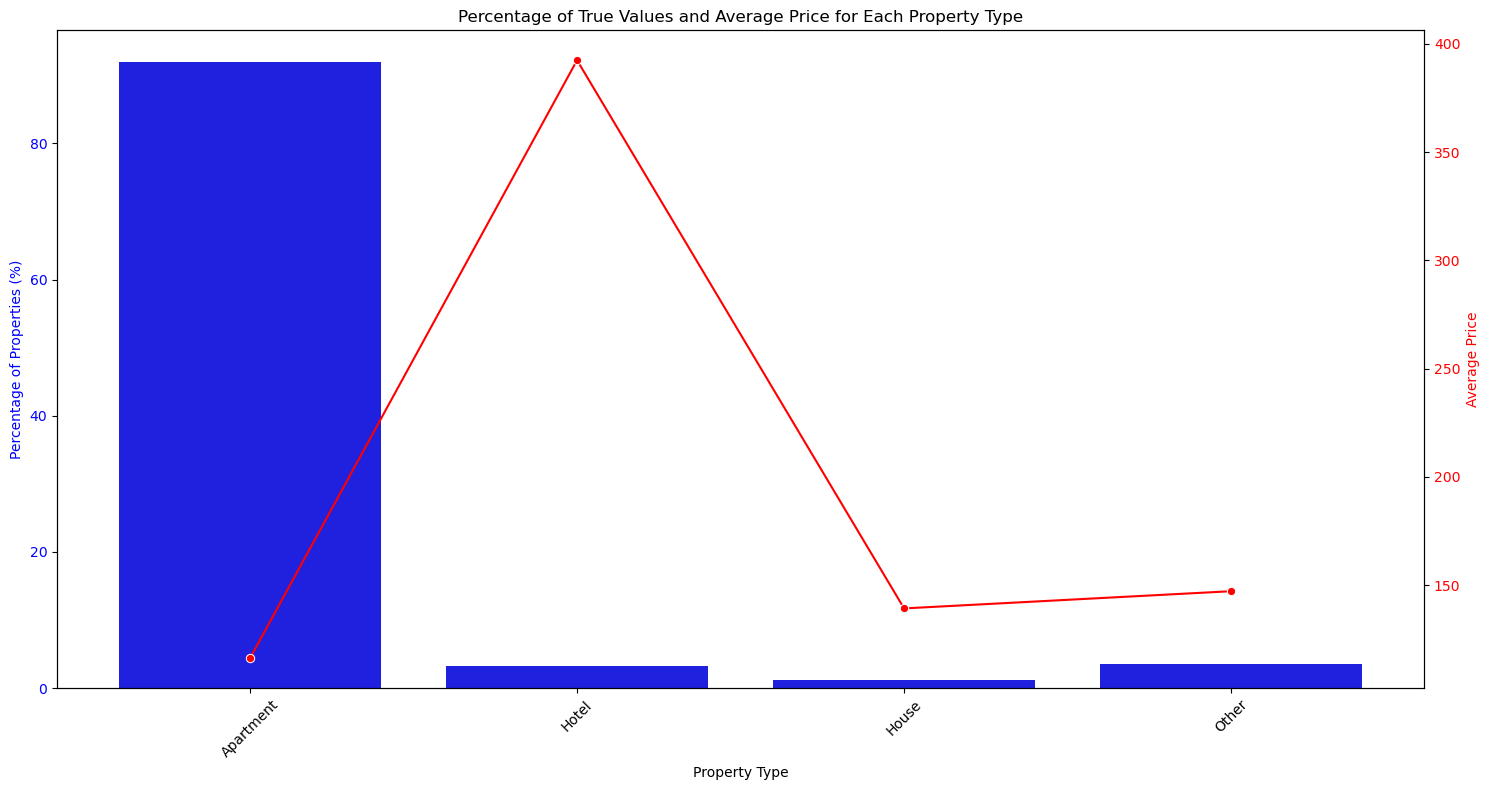

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define the figure size
figsize = (15, 8)

# Identify columns that start with "property_type"
property_type_columns = [col for col in dataframe1.columns if col.startswith('property_type')]

# Calculate the total number of rows in the dataframe
total_rows = len(dataframe1)

# Calculate the percentage of True values and average price for each property type
property_type_percentages = dataframe1[property_type_columns].sum() / total_rows * 100
average_prices = []

for col in property_type_columns:
    # Calculate the average price where the property type is True
    avg_price = dataframe1.loc[dataframe1[col] == True, 'price'].mean()
    average_prices.append(avg_price)

# Strip 'property_type_' prefix from property type column names
property_type_labels = [col.replace('property_type_', '') for col in property_type_columns]

# Combine the percentages and average prices into a DataFrame for plotting
comparison_df = pd.DataFrame({
    'Property Type': property_type_labels,
    'Percentage of Properties (%)': property_type_percentages.values,
    'Average Price': average_prices
})

# Plotting
fig, ax1 = plt.subplots(figsize=figsize)

# Plot the percentage of True values
sns.barplot(x='Property Type', y='Percentage of Properties (%)', data=comparison_df, ax=ax1, color='blue')
ax1.set_ylabel('Percentage of Properties (%)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
plt.xticks(rotation=45)

# Create a second y-axis for the average price
ax2 = ax1.twinx()
sns.lineplot(x='Property Type', y='Average Price', data=comparison_df, ax=ax2, color='red', marker='o')
ax2.set_ylabel('Average Price', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Percentage of True Values and Average Price for Each Property Type')
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Showing the distribution between price and the number of bedrooms
figsize = (10, 5)
x = 'accommodates'

# Create a grid with 1 row and 1 column
fig = plt.figure(figsize=figsize)
gs = GridSpec(1, 1)

# Bar plot for price distribution
ax1 = plt.subplot(gs[0])
sns.barplot(data=dataframe1, x=x, y='price', ax=ax1)
ax1.set_title(f'Distribution of Price based on {x}')

# Calculate the percentage of each bedroom count relative to all listings
bedroom_percentage = dataframe1[x].value_counts(normalize=True) * 100

# Display the percentage of each bedroom count
for bedrooms, percentage in bedroom_percentage.items():
    print(f'The percentage of listings with {bedrooms} bedroom(s) is: {percentage:.2f}%')

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Showing the distribution between price and the number of bedrooms
figsize = (10, 5)
x = 'total_amenities'

# Create a grid with 1 row and 1 column
fig = plt.figure(figsize=figsize)
gs = GridSpec(1, 1)

# Bar plot for price distribution
ax1 = plt.subplot(gs[0])
sns.barplot(data=dataframe1, x=x, y='price', ax=ax1)
ax1.set_title(f'Distribution of Price based on {x}')

# Calculate the percentage of each bedroom count relative to all listings
amenities_percentage = dataframe1[x].value_counts(normalize=True) * 100

# Display the percentage of each bedroom count
for total_amenities, percentage in amenities_percentage.items():
    print(f'The percentage of listings with {total_amenities} amenities is: {percentage:.2f}%')

plt.tight_layout()
plt.show()

In [ ]:
import folium
from folium.plugins import FloatImage
import pandas as pd
from branca.colormap import LinearColormap

# Assuming dataframe1 is loaded with appropriate 'longitude' and 'latitude' columns and 'price' column
sub_6 = dataframe1[dataframe1.price < 600]

# Create a map centered around an average location
paris_map = folium.Map(location=[sub_6['latitude'].mean(), sub_6['longitude'].mean()], zoom_start=13)

# Define color scale
color_scale = LinearColormap(['green', 'yellow', 'orange', 'pink', 'purple', 'brown', 'red', 'blue'],
                             vmin=sub_6['price'].min(), vmax=sub_6['price'].max(),
                             caption='Price Scale')  # This caption will be displayed on the legend

# Add points to the map
for idx, row in sub_6.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,
        color=color_scale(row['price']),
        fill=True,
        fill_color=color_scale(row['price']),
        fill_opacity=0.7
    ).add_to(paris_map)

# Add the color scale to the map
paris_map.add_child(color_scale)

# Save or display the map
#paris_map.save('paris_price_map.html')

# If you want to display the image in a Jupyter notebook:
paris_map

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'dataframe1' contains 'price', 'review_scores_rating', and 'neighbourhood'
dataframe1['review_scores_rating'] = pd.to_numeric(dataframe1['review_scores_rating'], errors='coerce')  # Convert to numeric if not already

# Group by 'neighbourhood' and calculate the mean price and mean review score
neighbourhood_stats = dataframe1.groupby('neighbourhood').agg({
    'price': 'mean',
    'review_scores_rating': 'mean'
}).reset_index()

# Drop any rows with NaN values that may interfere with visualization
neighbourhood_stats.dropna(inplace=True)

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(x='review_scores_rating', y='price', data=neighbourhood_stats, color='blue', s=100)

# Adjust the size of the title and labels
plt.xlabel('Average Review Score', fontsize=18)
plt.ylabel('Average Housing Price', fontsize=15)
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatter plot of availability_365 vs price without neighborhood distinction
#plt.figure(figsize=(10, 6))

# Using a single color for all points
#plt.scatter(dataframe1['availability_365'], dataframe1['price'], alpha=0.5)

#plt.xlabel('Availability over 365 days')
#plt.ylabel('Price')
#plt.title('Availability vs Price')
#plt.show()

plt.figure(figsize=(10, 6))

# Using a higher gridsize for more detail
# Applying a logarithmic scale with 'norm' and setting a minimum count threshold for display with 'mincnt'
plt.hexbin(dataframe1['availability_365'], dataframe1['price'], gridsize=100, cmap='Blues', bins='log', mincnt=1)
plt.colorbar()

plt.xlabel('Availability over 365 days')
plt.ylabel('Price')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import folium
import matplotlib.pyplot as plt
from matplotlib import cm, colors

# Sample data loading
# dataframe1 = pd.read_csv('path_to_your_data.csv')  # Assuming the dataset is read in as dataframe1

# Step 1: Select a random date from the dataset
random_date = dataframe1['date'].sample(1).iloc[0]

# Step 2: Filter the dataset for the selected date
filtered_data = dataframe1[dataframe1['date'] == random_date]

# Step 3: Aggregate the pricing information
# Assuming the dataset has 'id', 'latitude', 'longitude', and 'price' columns
aggregated_data = filtered_data.groupby(['id', 'latitude', 'longitude']).agg({'price': 'mean'}).reset_index()

# Step 4: Create a base map centered on Paris
map_paris = folium.Map(location=[48.8566, 2.3522], zoom_start=12)

# Step 5: Normalize the prices for color mapping using a logarithmic scale
aggregated_data['log_price'] = np.log1p(aggregated_data['price'])  # Apply log scale
min_price_log = aggregated_data['log_price'].min()
max_price_log = aggregated_data['log_price'].max()
norm = colors.Normalize(vmin=min_price_log, vmax=max_price_log)
colormap = cm.ScalarMappable(norm=norm, cmap='YlGnBu')

# Step 6: Add markers to the map with colors indicating price
for _, row in aggregated_data.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color=colors.to_hex(colormap.to_rgba(row['log_price'])),
        fill=True,
        fill_color=colors.to_hex(colormap.to_rgba(row['log_price'])),
        fill_opacity=0.7,
        popup=f"ID: {row['id']}<br>Price: €{row['price']:.2f}"
    ).add_to(map_paris)

# Step 7: Add a color legend to the map
# Create a legend as an HTML string
legend_html = f"""
<div style="position: fixed; 
            bottom: 50px; left: 50px; width: 200px; height: 150px; 
            border:2px solid grey; z-index:9999; font-size:14px;
            background-color:white; padding: 10px;">
    <h4 style="margin-bottom:10px;">Price Legend (€)</h4>
    <div style="background:linear-gradient(to right, {colors.to_hex(colormap.to_rgba(min_price_log))}, {colors.to_hex(colormap.to_rgba(max_price_log))});height:20px;width:100%;"></div>
    <div style="display:flex;justify-content:space-between;margin-top:5px;">
        <span>{np.expm1(min_price_log):.2f}</span><span>{np.expm1(max_price_log):.2f}</span>
    </div>
</div>
"""
map_paris.get_root().html.add_child(folium.Element(legend_html))

# Save map to HTML file
#map_paris.save('paris_airbnb_price_map.html')

# Display the map in a Jupyter notebook (optional, requires Jupyter environment)
map_paris